The first step of preprocessing for the data we are using in class will be cleaning it for initial visualization. The comment bodies will need escape sequences removed, emojis/invalid characters parsed and removed, and any other issues in our data that could prevent a seamless exploration.

In [2]:
#package and data importing and loading
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')

subreddits = ["kanye", "askScience", "PoliticalDiscussion", "socialism"]

#comments are pulled from the top 40 posts from the past month in each subreddit.
dataframes = []
for sub in subreddits:
    df = pd.read_csv(f"data/comments_{sub}.csv")
    dataframes.append(df)

In [3]:
print(dataframes[0].columns)
for i in range(len(dataframes)):
    print(subreddits[i])
    print(dataframes[i].shape)

Index(['postTag', 'user', 'comment_score', 'comment_body', 'mod_deleted',
       'user_deleted', 'verified', 'is_gold', 'has_verified_email',
       'link_karma', 'total_karma', 'created_utc', 'comment_karma'],
      dtype='object')
kanye
(42654, 13)
askScience
(11134, 13)
PoliticalDiscussion
(31235, 13)
socialism
(3038, 13)


Drop comments that were removed too quickly and so were not archived. Also drop comments automatically generated by mods.

In [24]:
urlRegex = r"(https? *:*\/*\/*)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"
mods = ["https://www.reddit.com/user/AutoModerator", "https://www.reddit.com/user/socialism-ModTeam"]
for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].dropna(subset=["user"])
    dataframes[i] = dataframes[i][~dataframes[i]["user"].isin(mods)]
    for col in ['verified', 'is_gold', 'has_verified_email']:
        dataframes[i][col] = dataframes[i][col].apply(lambda x: 1 if x else 0)
    dataframes[i]['comment_body'] = dataframes[i]['comment_body'].apply(lambda x: re.sub(urlRegex, ' ', x))
    print(subreddits[i])
    print(dataframes[i].shape)

kanye
(40436, 13)
askScience
(6679, 13)
PoliticalDiscussion
(28026, 13)
socialism
(2620, 13)


The distribution of the target is very uneven so we need to make sure we don't overfit on the majority class.


In [5]:
for i in range(len(dataframes)):
    print(subreddits[i])
    print(dataframes[i].groupby(["mod_deleted"]).size())
    print(dataframes[i].groupby(["user_deleted"]).size())
    print()

kanye
mod_deleted
0    39584
1      852
dtype: int64
user_deleted
0    38187
1     2249
dtype: int64

askScience
mod_deleted
0    5146
1    1533
dtype: int64
user_deleted
0    6570
1     109
dtype: int64

PoliticalDiscussion
mod_deleted
0    27189
1      837
dtype: int64
user_deleted
0    27361
1      665
dtype: int64

socialism
mod_deleted
0    2392
1     228
dtype: int64
user_deleted
0    2559
1      61
dtype: int64



In [ ]:
#cleaning escape sequences, invalid words, deleted comments, and other things that won't serve to help our analysis. regex?

Our analysis will be looking at which variables (from the data we collected) are the most useful in classifying whether a comment gets deleted, and if so, whether the user deleted it themselves, or a moderator deleted it. Can we predict based on certain keywords, or a threshold for karma, or any other classifers, what the outcome of the comments status will be? Could this information we use be utilized to enhance the auto moderator currently used on reddit?

The main classifier/variable we are studying will obviously be the comment bodies, as that content will be most critical to parsing the synoposis of messages that routinely get deleted or not. Thus, the data will be mostly free text, with no predefined features. As such, we will use multiple techniques to create training data to be used in model selection and training. Correlations discovered between account creation, comment karma, will be observed but will require less cleaning.

In [17]:
#CountVectorizer 
#We will use CountVectorizer during vectorization of datasets.

comments_trans = []

# Added stemming to vectorization but may not be necessary, max_df has a bigger impact
porter = SnowballStemmer("english")
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

for i in range(len(dataframes)):
    comments = dataframes[i]["comment_body"].apply(lambda x: " ".join(tokenizer_porter(x)))
    vect = CountVectorizer(stop_words=stopwords.words('english'),max_df=.5, ngram_range=(1,2) ,max_features=50, strip_accents="unicode")
    vect.fit(comments)
    print(subreddits[i])
    print(vect.get_feature_names_out())
    print()
    comments_trans.append(vect.transform(comments).toarray())
    vect = CountVectorizer(stop_words=stopwords.words('english'),max_df=.5, ngram_range=(2,2) ,max_features=25, strip_accents="unicode")
    vect.fit(comments)
    print(vect.get_feature_names_out())
    print()


kanye
['actual' 'also' 'ani' 'becaus' 'black' 'call' 'even' 'fuck' 'get' 'go'
 'jew' 'jewish' 'kany' 'know' 'like' 'lol' 'make' 'man' 'mean' 'music'
 'need' 'one' 'onli' 'peopl' 'person' 'point' 'realli' 'remov'
 'remov within' 'right' 'said' 'say' 'seconds' 'see' 'shit' 'someon'
 'still' 'take' 'talk' 'thing' 'think' 'time' 'tri' 'want' 'way' 'whi'
 'white' 'within' 'would' 'ye']

['15 seconds' 'act like' 'anti semit' 'black peopl' 'black people'
 'feel like' 'georg floyd' 'get help' 'https www' 'jewish peopl'
 'jewish people' 'kany west' 'look like' 'mental health' 'mental ill'
 'peopl like' 'piec shit' 'remov within' 'seem like' 'sound like'
 'white peopl' 'within 13' 'within 14' 'within 15' 'within 16']

askScience
['12' '13' '14' '15' '17' '17 seconds' 'actual' 'also' 'ani' 'becaus'
 'bodi' 'caus' 'cell' 'could' 'differ' 'earth' 'even' 'get' 'go' 'know'
 'like' 'lot' 'make' 'much' 'one' 'onli' 'peopl' 'realli' 'remov'
 'remov within' 'seconds' 'see' 'still' 'system' 'take' 'thing'

In [7]:
comments_trans[0]

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
#TF-IDF Rescaling Calculations. -> [Utilizing a param grid or pipeline could simplify this process.]
#-> A statistical measure to evaluate how relevant a word is to a document.
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
kanye_tfidf = make_pipeline(CountVectorizer(stop_words=stopwords.words('english'), max_features=10), TfidfTransformer()).fit_transform(kanyeData['comment_body'].apply(lambda x: " ".join(x)))
kanye_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.76848418],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
#N-grams
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {"countvectorizer__ngram_range":[(1, 2), (2, 5)],
              "countvectorizer__min_df": [2, 3]
             }

grid = GridSearchCV(make_pipeline(CountVectorizer(analyzer="char"), LogisticRegression()), param_grid=param_grid,
                                  cv=10, scoring="f1_macro", return_train_score=True)

In [4]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
x = ['postTag', 'comment_body', 'comment_score', 'verified', 'is_gold', 'has_verified_email',
       'link_karma', 'total_karma', 'created_utc', 'comment_karma']
y = "mod_deleted"
x_cont = x[2:]
x_text = 'comment_body'


training before resampling: mod_deleted
0    23511
1     1608
dtype: int64
kanye
Best Training Score: 0.8946417180523071, Best Params: {'vect__use_idf': True, 'vect__tokenizer': None, 'vect__strip_accents': None, 'vect__stop_words': None, 'vect__norm': 'l2', 'vect__ngram_range': (2, 2), 'vect__max_features': 50, 'clf__solver': 'sparse_cg', 'clf__alpha': 100.0}
Test Score: 0.97473624180211
Test set size mod_deleted
0    16338
1     1197
Name: mod_deleted, dtype: int64


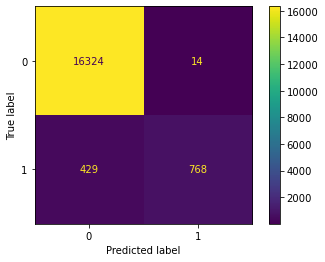


training before resampling: mod_deleted
0    2381
1    2618
dtype: int64
askScience
Best Training Score: 0.8780534351145037, Best Params: {'vect__use_idf': True, 'vect__tokenizer': None, 'vect__strip_accents': None, 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 

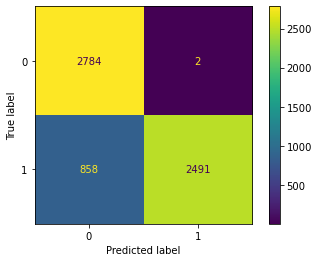


training before resampling: mod_deleted
0    13176
1     1810
dtype: int64
PoliticalDiscussion
Best Training Score: 0.9073216995447646, Best Params: {'vect__use_idf': False, 'vect__tokenizer': None, 'vect__strip_accents': None, 'vect__stop_words': None, 'vect__norm': 'l2', 'vect__ngram_range': (1, 1), 'vect__max_features': 50, 'clf__solver': 'sag', 'clf__alpha': 3.1622776601683795}
Test Score: 0.9620284325189242
Test set size mod_deleted
0    14133
1     2116
Name: mod_deleted, dtype: int64


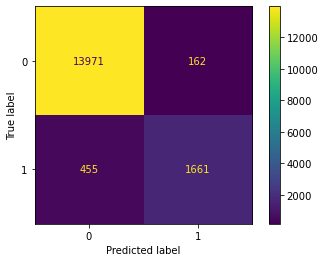


training before resampling: mod_deleted
0    1180
1     244
dtype: int64
socialism
Best Training Score: 0.8080508474576271, Best Params: {'vect__use_idf': True, 'vect__tokenizer': None, 'vect__strip_accents': 'ascii', 'vect__stop_words': None, 'vect__norm': 'l2', 'vect__ngram_range': (1, 1), 'vect__max_features': 50, 'clf__solver': 'sag', 'clf__alpha': 3.1622776601683795}
Test Score: 0.8736059479553904
Test set size mod_deleted
0    1331
1     283
Name: mod_deleted, dtype: int64


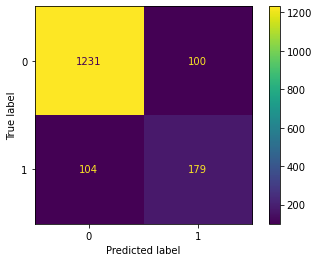

In [9]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay

#y is our target, what we are trying to predict. That is either deleted by mod or deleted by user (if deleted at all). Two splits.
for i in range(len(dataframes)):
    df = dataframes[i]
    tfidf = TfidfVectorizer(max_df=.5)
    # Use grouped split so that comments from a posts are not split between training & test set
    X = df[x]
    Y = df[y]
    Y = Y.apply(lambda x: "1" if x else "0")
    gs = GroupShuffleSplit(n_splits=2, test_size=.5, random_state=0)
    train_ind, test_ind = next(gs.split(X, Y, groups=X.postTag))
    X_test = X.iloc[test_ind].drop("postTag", axis=1)
    y_test = Y.iloc[test_ind]
    # Duplicate minority class to match majority class to avoid overfitting
    X_train = X.iloc[train_ind].drop("postTag", axis=1)
    
    y_train = Y.iloc[train_ind]
    train = pd.concat([X_train, y_train], axis=1)
    print(f"training before resampling: {train.groupby(by=train[y]).size()}")
    root = [train]
    size = train[y].value_counts().max()
    for class_index, group in train.groupby(y):
        root.append(group.sample(size-len(group), replace=True))
    train = pd.concat(root)
    X_train = train[x_text]
    y_train = train[y]
    
    # Create model pipeline & param_grids
    param_grid = ({'vect__ngram_range': [(1,1), (1,4), (2,2), (1,8)],
                   'vect__stop_words': [stopwords.words('english'), None],
                   'vect__tokenizer': [None],
                   'vect__max_features': [25, 50],
                   'vect__use_idf': [True, False],
                   'vect__norm': ['l1', 'l2'],
                   'vect__strip_accents': ['ascii', None],
                   'clf__alpha': np.logspace(-4,2,5),
                   'clf__solver': ["sparse_cg", "sag"]
                  })
    pipeline = Pipeline([('vect', tfidf),
                        ('clf', RidgeClassifier(max_iter=100000))])
    
    grid = RandomizedSearchCV(estimator=pipeline,n_iter=100,n_jobs=-1, param_distributions=param_grid, return_train_score=True, 
                             cv=ShuffleSplit())
    grid.fit(X_train, y_train)
    print(subreddits[i])
    print(f"Best Training Score: {grid.best_score_}, Best Params: {grid.best_params_}")
    print(f"Test Score: {grid.score(X_test[x_text], y_test)}")
    print(f"Test set size {y_test.groupby(y_test).size()}")
    model = grid.best_estimator_
    y_pred = model.predict(X_test[x_text])
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay

#y is our target, what we are trying to predict. That is either deleted by mod or deleted by user (if deleted at all). Two splits.
for i in range(len(dataframes)):
    df = dataframes[i]
    tfidf = TfidfVectorizer(max_df=.5)
    # Use grouped split so that comments from a posts are not split between training & test set
    X = df[x]
    Y = df[y]
    Y = Y.apply(lambda x: "1" if x else "0")
    gs = GroupShuffleSplit(n_splits=2, test_size=.5, random_state=0)
    train_ind, test_ind = next(gs.split(X, Y, groups=X.postTag))
    X_test = X.iloc[test_ind].drop("postTag", axis=1)
    y_test = Y.iloc[test_ind]
    # Duplicate minority class to match majority class to avoid overfitting
    X_train = X.iloc[train_ind].drop("postTag", axis=1)
    
    y_train = Y.iloc[train_ind]
    train = pd.concat([X_train, y_train], axis=1)
    print(f"training before resampling: {train.groupby(by=train[y]).size()}")
    root = [train]
    size = train[y].value_counts().max()
    for class_index, group in train.groupby(y):
        root.append(group.sample(size-len(group), replace=True))
    train = pd.concat(root)
    X_train = train[x_text]
    y_train = train[y]
    
    # Create model pipeline & param_grids
    param_grid = ({'vect__ngram_range': [(1,1), (1,4), (2,2), (1,8)],
                   'vect__stop_words': [stopwords.words('english'), None],
                   'vect__tokenizer': [None],
                   'vect__max_features': [25, 50],
                   'vect__use_idf': [True, False],
                   'vect__norm': ['l1', 'l2'],
                   'vect__strip_accents': ['ascii', None],
                   'clf__n_estimators': np.arange(50 ,500,50),
                  })
    pipeline = Pipeline([('vect', tfidf),
                        ('clf', AdaBoostClassifier(algorithm="SAMME"))])
    
    grid = RandomizedSearchCV(estimator=pipeline,n_iter=100,n_jobs=-1, param_distributions=param_grid, return_train_score=True, 
                             cv=ShuffleSplit())
    grid.fit(X_train, y_train)
    print(subreddits[i])
    print(f"Test set size {y_test.groupby(y_test).size()}")
    print(f"Best Training Score: {grid.best_score_}, Best Params: {grid.best_params_}")
    print(f"Test Score: {grid.score(X_test[x_text], y_test)}")
    model = grid.best_estimator_
    y_pred = model.predict(X_test[x_text])
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print()

training before resampling: mod_deleted
0    23511
1     1608
dtype: int64
